
# Waves on a string

Codi d'exemple de la documentació de Dedalus.

2025-04-24 10:26:10,467 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.0e+01/s
evals.size (before)  130
evals.size (after removing inf)  126
evals.size (after removing < 0)  126
First 4 Eigenvalues (sqrt): [  9.8696044 +0.j  39.4784176 -0.j  88.82643961-0.j 157.91367042+0.j]
First 4 True eigenvalues: [  9.8696044   39.4784176   88.82643961 157.91367042]


/Users/joanribot/opt/anaconda3/envs/dedalus3/lib/python3.12/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


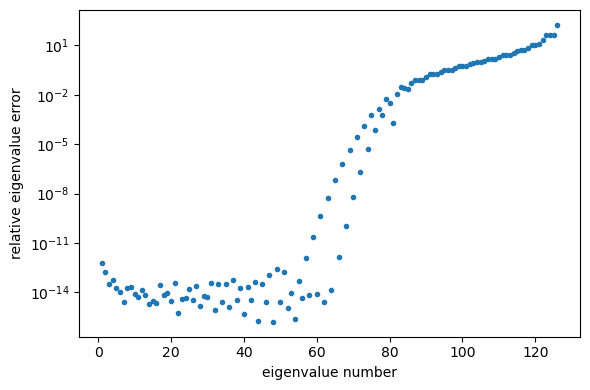

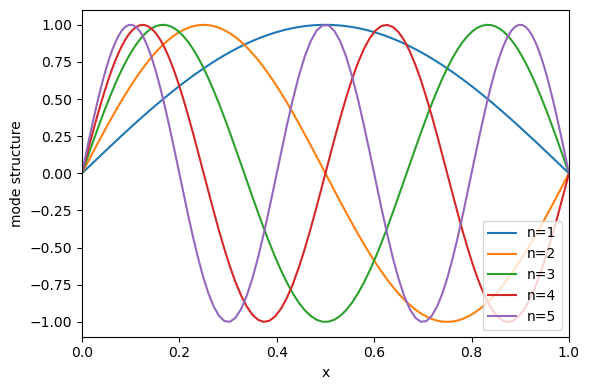

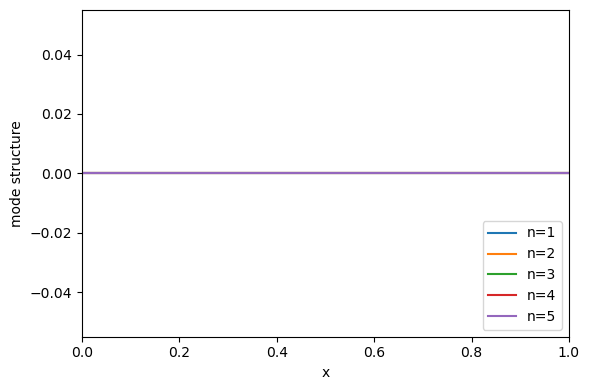

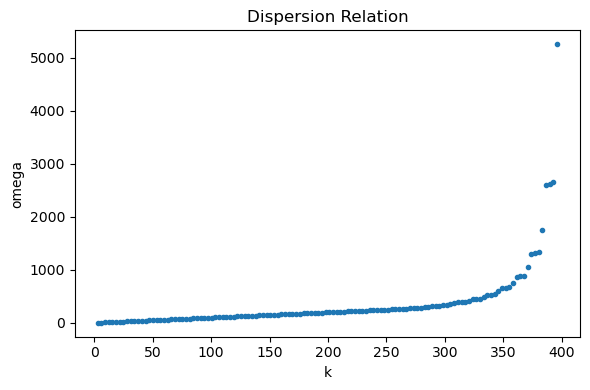

In [ ]:
"""
Dedalus script computing the eigenmodes of waves on a clamped string.
This script demonstrates solving a 1D eigenvalue problem and produces
plots of the first few eigenmodes and the relative error of the eigenvalues.
It should take just a few seconds to run (serial only).

We use a Legendre basis to solve the EVP:
    s*u + dx(dx(u)) = 0
    u(x=0) = 0
    u(x=Lx) = 0
where s is the eigenvalue.

For the second derivative on a closed interval, we need two tau terms.
Here we choose to use a first-order formulation, putting one tau term
on an auxiliary first-order variable and another in the PDE, and lifting
both to the first derivative basis.

To run and plot:
    $ python3 waves_on_a_string.py
"""

import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as d3
import logging
logger = logging.getLogger(__name__)


# Parameters
Lx = 1
Nx = 128
dtype = np.complex128

# Bases
xcoord = d3.Coordinate('x')
dist = d3.Distributor(xcoord, dtype=dtype)
xbasis = d3.Legendre(xcoord, size=Nx, bounds=(0, Lx)) # Amb Chebyshev crec que l'error oscil·la manco

# Fields
u = dist.Field(name='u', bases=xbasis)
tau_1 = dist.Field(name='tau_1')
tau_2 = dist.Field(name='tau_2')
s = dist.Field(name='s')

# Substitutions
dx = lambda A: d3.Differentiate(A, xcoord)
lift_basis = xbasis.derivative_basis(1)
lift = lambda A: d3.Lift(A, lift_basis, -1)
ux = dx(u) + lift(tau_1) # First-order reduction
uxx = dx(ux) + lift(tau_2) # Second-order reduction

# Problem
problem = d3.EVP([u, tau_1, tau_2], eigenvalue=s, namespace=locals())
problem.add_equation("s*u + uxx = 0")
problem.add_equation("u(x=0) = 0")
problem.add_equation("u(x=Lx) = 0")

# Solve
solver = problem.build_solver()
solver.solve_dense(solver.subproblems[0])
evals = np.sort(solver.eigenvalues)
n = 1 + np.arange(evals.size)
true_evals = (n * np.pi / Lx)**2
relative_error = np.abs(evals - true_evals) / true_evals

# Print eigenvalues
print('evals.size (before) ', evals.size)
evals = evals[~np.isinf(evals)] # el ~ és un operador bitwise NOT, que retorna True si el valor és False i viceversa. En aquest cas elimina els valors infinits
print('evals.size (after removing inf) ', evals.size)
evals = evals[evals > 0] # eliminam els valors negatius
print('evals.size (after removing < 0) ', evals.size)

# Plot error
plt.figure(figsize=(6, 4))
plt.semilogy(n, relative_error, '.')
plt.xlabel("eigenvalue number")
plt.ylabel("relative eigenvalue error")
plt.tight_layout()
# plt.savefig("eigenvalue_error.pdf")
# plt.savefig("eigenvalue_error.png", dpi=200)

# Plot real part
plt.figure(figsize=(6, 4))
x = dist.local_grid(xbasis)
for n, idx in enumerate(np.argsort(solver.eigenvalues)[:5], start=1):
    solver.set_state(idx, solver.subsystems[0])
    ug = (u['g'] / u['g'][1]).real
    plt.plot(x, ug/np.max(np.abs(ug)), label=f"n={n}")
plt.xlim(0, 1)
plt.legend(loc="lower right")
plt.ylabel(r"mode structure")
plt.xlabel(r"x")
plt.tight_layout()
# plt.savefig("eigenvectors.pdf")
# plt.savefig("eigenvectors.png", dpi=200)

'''
This is a multiline comment.
It can be used to describe the code, its purpose, and any important details.
It can also be used to provide instructions for running the code or to explain the output.
'''


# Plot imag part
plt.figure(figsize=(6, 4))
x = dist.local_grid(xbasis)
for n, idx in enumerate(np.argsort(solver.eigenvalues)[:5], start=1):
    solver.set_state(idx, solver.subsystems[0])
    
    # ens interessa part Im per comnprovar que està bé
    ui = (u['g'] / u['g'][1]).imag
    
    plt.plot(x, ui, label=f"n={n}") # no normalitzam pq ens divideix per 0
plt.xlim(0, 1)
plt.legend(loc="lower right")
plt.ylabel(r"mode structure")
plt.xlabel(r"x")
plt.tight_layout()
# plt.savefig("eigenvectors.pdf")
# plt.savefig("eigenvectors.png", dpi=200)

print("First 4 Eigenvalues (sqrt):", evals[:4])
print("First 4 True eigenvalues:", true_evals[:4])

# Dispersion relation

n = 1 + np.arange(evals.size)
k = n * np.pi / Lx
omega = np.sqrt(evals[:n.size])


plt.figure(figsize=(6, 4))
plt.plot(k, omega, '.')
plt.xlabel("k")
plt.ylabel("omega")
plt.title("Dispersion Relation")
plt.tight_layout()
plt.show()


In [ ]:
# Shift + Option + Mouse per seleccionar moltes línies
# Shift + Command + 7 per comentar-les


In [3]:
# Google collab